# Creating crosslinked polymers with SwiftPol.crosslink

This code uses SwiftPol's framework to build a chain of Polyethylene Glycol Diacrylate (PEGDA) and build a large crosslinked polymer network.


In [2]:
# Imports
from rdkit import Chem
from rdkit.Chem import AllChem
import random

from swiftpol import build, crosslink

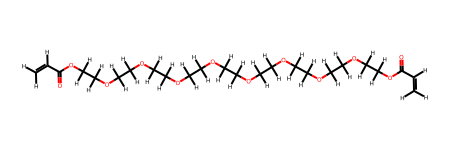

In [3]:
# Build linear PEGDA chain
monomer = ["IC=CC(=O)OI", "IOCCOI"] # PEGDA monomers with iodinated polymerization points
reaction = AllChem.ReactionFromSmarts('[C:1]-[O:2]-[I:3].[C:4]-[O:5]-[I:6]>>[C:1]-[O:2]-[C:4].[I:3]-[I:6].[O:5]')
sequence = 'ABBBBBBBBBA' # SwiftPol can easily build irregular sequence motifs
polymer = build.build_polymer(sequence = sequence,
                                monomer_list = monomer,
                                reaction = reaction,
                                terminal = 'hydrogen',
                                chainID='A')
polymer

For PEGDA, either a linear or branched addition is possible.

We can use halogens to guide SwiftPol to the correct crosslinking sites

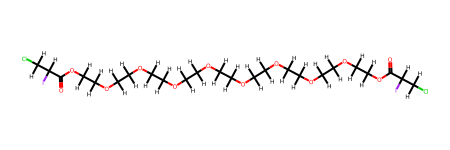

In [4]:
# Activation
activation_reaction=AllChem.ReactionFromSmarts('[C:1]=[C:2].[Cl:3].[I:4]>>[C:1](-[I:4])-[C:2]-[Cl:3]')
activatorCl = Chem.MolFromSmiles('Cl')
activatorI = Chem.MolFromSmiles('I')

# Apply activation reaction twice
starting_polymer = activation_reaction.RunReactants([polymer, activatorCl, activatorI])[0][0]
Chem.SanitizeMol(starting_polymer)

starting_polymer = activation_reaction.RunReactants([starting_polymer, activatorCl, activatorI])[0][0]
Chem.SanitizeMol(starting_polymer)

Chem.AddHs(starting_polymer)

In [5]:
# Linear addition
reaction_templates = {'linear' : ['[C:1][I:2].[C:3][Cl:4]>>[C:1][C:3].[I:2].[Cl:4]'],
                     'branched' : ['[C:1][Br:2].[C:3][Cl:4]>>[C:1][C:3].[Br:2].[Cl:4]']}
linear_addition = AllChem.ReactionFromSmarts(reaction_templates['linear'][0])

linear_polymer = linear_addition.RunReactants([starting_polymer, starting_polymer])[0][0]

For branched addition, we can pick a random point on the PEGDA chain to add a branch.

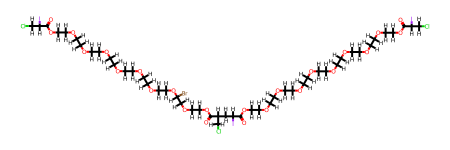

In [6]:
# Branched addition
activation_reaction=AllChem.ReactionFromSmarts('[C:1]-[C:2](-[H:5])-[O:4].[Br:3]>>[C:1]-[C:2](-[Br:3])-[O:4].[H:5]')
activatorBr = Chem.MolFromSmiles('Br')
activated_for_branching = activation_reaction.RunReactants([linear_polymer, activatorBr])[5][0]

Chem.SanitizeMol(activated_for_branching)
activated_for_branching

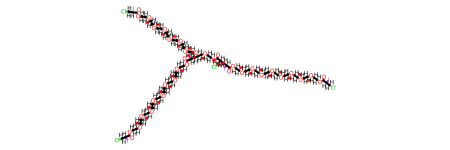

In [7]:
branched_addition = AllChem.ReactionFromSmarts(reaction_templates['branched'][0])
branched_polymer = branched_addition.RunReactants([activated_for_branching, starting_polymer])[0][0]
Chem.SanitizeMol(branched_polymer)
branched_polymer

To create crosslinks, find close unreacted halogens (in this case, chlorine) and form bonds

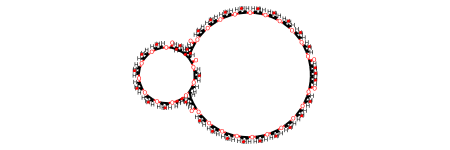

In [8]:
network = crosslink.iterative_crosslink(branched_polymer)
clean_network = crosslink.replace_halogens_with_hydrogens(network)
clean_network

### Bringing it all together

In [11]:
reaction_templates = {'linear_activate' : ['[C:1]=[C:2].[Cl:3].[I:4]>>[C:1](-[I:4])-[C:2]-[Cl:3]', 'Cl', 'I'],
                      'linear_react' : ['[C:1][I:2].[C:3][Cl:4]>>[C:1][C:3].[I:2].[Cl:4]'],
                      'branched_activate' : ['[C:1]-[C:2](-[H:5])-[O:4].[Br:3]>>[C:1]-[C:2](-[Br:3])-[O:4].[H:5]', 'Br'],
                      'branched_react' : ['[C:1][Br:2].[C:3][Cl:4]>>[C:1][C:3].[Br:2].[Cl:4]']}

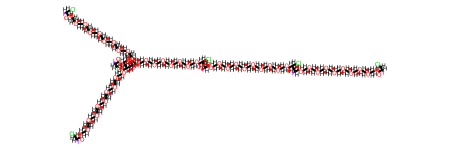

In [12]:
# Build a branched system based on number of iterations/chains added
branched_iter = crosslink.build_branched_polymer(starting_polymer = polymer,
                                            reaction_templates = reaction_templates,
                                            num_iterations=4, 
                                            probability_of_branched_addition=0.5, 
                                            probability_of_linear_addition=0.5)
branched_iter

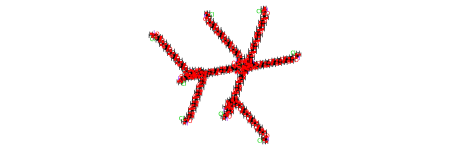

In [13]:
# Build up a larger branched system to a target molecular weight
branched_mw = crosslink.build_branched_polymer(starting_polymer = polymer,
                                               reaction_templates = reaction_templates,
                                               target_mw=5000, 
                                               probability_of_branched_addition=0.5, 
                                               probability_of_linear_addition=0.5)
branched_mw

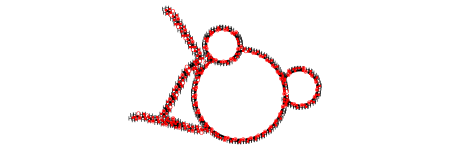

In [16]:
# Crosslink chains and clean up halogens
crosslink.crosslink_polymer(branched_mw, percentage_to_crosslink=80)